In [1]:
from sklearn.datasets import load_iris
import pandas as pd
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("IrisFromSklearn").getOrCreate()

iris_sk = load_iris()
pdf = pd.DataFrame(iris_sk.data, columns=iris_sk.feature_names)
pdf['species'] = pd.Categorical.from_codes(iris_sk.target, iris_sk.target_names)

# Spark DataFrame
iris = spark.createDataFrame(pdf)

iris.show(5)
iris.printSchema()

25/10/07 20:47:26 WARN Utils: Your hostname, huawei-matebook14.local resolves to a loopback address: 127.0.0.1; using 10.249.10.205 instead (on interface en0)
25/10/07 20:47:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/07 20:47:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-----------------+----------------+-----------------+----------------+-------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|species|
+-----------------+----------------+-----------------+----------------+-------+
|              5.1|             3.5|              1.4|             0.2| setosa|
|              4.9|             3.0|              1.4|             0.2| setosa|
|              4.7|             3.2|              1.3|             0.2| setosa|
|              4.6|             3.1|              1.5|             0.2| setosa|
|              5.0|             3.6|              1.4|             0.2| setosa|
+-----------------+----------------+-----------------+----------------+-------+
only showing top 5 rows

root
 |-- sepal length (cm): double (nullable = true)
 |-- sepal width (cm): double (nullable = true)
 |-- petal length (cm): double (nullable = true)
 |-- petal width (cm): double (nullable = true)
 |-- species: string (nullable = true)



In [2]:
iris = iris.withColumnRenamed("sepal length (cm)", "sepal_length") \
           .withColumnRenamed("sepal width (cm)", "sepal_width") \
           .withColumnRenamed("petal length (cm)", "petal_length") \
           .withColumnRenamed("petal width (cm)", "petal_width")

In [3]:
iris.sample(0.1).show()

+------------+-----------+------------+-----------+----------+
|sepal_length|sepal_width|petal_length|petal_width|   species|
+------------+-----------+------------+-----------+----------+
|         4.9|        3.0|         1.4|        0.2|    setosa|
|         4.7|        3.2|         1.3|        0.2|    setosa|
|         4.9|        3.1|         1.5|        0.1|    setosa|
|         5.1|        3.5|         1.4|        0.3|    setosa|
|         5.1|        3.8|         1.5|        0.3|    setosa|
|         4.8|        3.1|         1.6|        0.2|    setosa|
|         5.5|        2.3|         4.0|        1.3|versicolor|
|         6.3|        3.3|         4.7|        1.6|versicolor|
|         4.9|        2.4|         3.3|        1.0|versicolor|
|         6.0|        2.2|         4.0|        1.0|versicolor|
|         6.6|        3.0|         4.4|        1.4|versicolor|
|         6.5|        3.2|         5.1|        2.0| virginica|
|         6.4|        2.7|         5.3|        1.9| vir

#### basic example of classification

In [4]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(outputCol="features").setInputCols(iris.columns[0:4])
preparedDF = va.transform(iris)

In [5]:
preparedDF.explain()

== Physical Plan ==
*(1) Project [sepal length (cm)#0 AS sepal_length#31, sepal width (cm)#1 AS sepal_width#37, petal length (cm)#2 AS petal_length#43, petal width (cm)#3 AS petal_width#49, species#4, UDF(struct(sepal_length, sepal length (cm)#0, sepal_width, sepal width (cm)#1, petal_length, petal length (cm)#2, petal_width, petal width (cm)#3)) AS features#77]
+- *(1) Scan ExistingRDD[sepal length (cm)#0,sepal width (cm)#1,petal length (cm)#2,petal width (cm)#3,species#4]




In [6]:
from pyspark.ml.feature import StringIndexer
str_id = StringIndexer(outputCol="label").setInputCol("species")
preparedDF = str_id.fit(preparedDF).transform(preparedDF)

In [7]:
preparedDF.sample(0.1).show()

+------------+-----------+------------+-----------+----------+-----------------+-----+
|sepal_length|sepal_width|petal_length|petal_width|   species|         features|label|
+------------+-----------+------------+-----------+----------+-----------------+-----+
|         4.9|        3.0|         1.4|        0.2|    setosa|[4.9,3.0,1.4,0.2]|  0.0|
|         4.3|        3.0|         1.1|        0.1|    setosa|[4.3,3.0,1.1,0.1]|  0.0|
|         5.1|        3.5|         1.4|        0.3|    setosa|[5.1,3.5,1.4,0.3]|  0.0|
|         5.1|        3.8|         1.5|        0.3|    setosa|[5.1,3.8,1.5,0.3]|  0.0|
|         5.4|        3.4|         1.5|        0.4|    setosa|[5.4,3.4,1.5,0.4]|  0.0|
|         5.0|        3.2|         1.2|        0.2|    setosa|[5.0,3.2,1.2,0.2]|  0.0|
|         5.0|        3.5|         1.3|        0.3|    setosa|[5.0,3.5,1.3,0.3]|  0.0|
|         4.8|        3.0|         1.4|        0.3|    setosa|[4.8,3.0,1.4,0.3]|  0.0|
|         7.0|        3.2|         4.7|    

In [8]:
train, test = preparedDF.randomSplit([.7, .3])

In [9]:
test.explain()

== Physical Plan ==
*(1) Sample 0.7, 1.0, false, 2169386071705808269
+- *(1) Sort [sepal_length#31 ASC NULLS FIRST, sepal_width#37 ASC NULLS FIRST, petal_length#43 ASC NULLS FIRST, petal_width#49 ASC NULLS FIRST, species#4 ASC NULLS FIRST, features#77 ASC NULLS FIRST, label#150 ASC NULLS FIRST], false, 0
   +- *(1) Project [sepal_length#31, sepal_width#37, petal_length#43, petal_width#49, species#4, features#77, UDF(species#4) AS label#150]
      +- *(1) Project [sepal length (cm)#0 AS sepal_length#31, sepal width (cm)#1 AS sepal_width#37, petal length (cm)#2 AS petal_length#43, petal width (cm)#3 AS petal_width#49, species#4, UDF(struct(sepal_length, sepal length (cm)#0, sepal_width, sepal width (cm)#1, petal_length, petal length (cm)#2, petal_width, petal width (cm)#3)) AS features#77]
         +- *(1) Scan ExistingRDD[sepal length (cm)#0,sepal width (cm)#1,petal length (cm)#2,petal width (cm)#3,species#4]




In [10]:
test.show(5)

+------------+-----------+------------+-----------+-------+-----------------+-----+
|sepal_length|sepal_width|petal_length|petal_width|species|         features|label|
+------------+-----------+------------+-----------+-------+-----------------+-----+
|         4.3|        3.0|         1.1|        0.1| setosa|[4.3,3.0,1.1,0.1]|  0.0|
|         4.4|        2.9|         1.4|        0.2| setosa|[4.4,2.9,1.4,0.2]|  0.0|
|         4.8|        3.0|         1.4|        0.1| setosa|[4.8,3.0,1.4,0.1]|  0.0|
|         5.4|        3.9|         1.7|        0.4| setosa|[5.4,3.9,1.7,0.4]|  0.0|
|         4.7|        3.2|         1.6|        0.2| setosa|[4.7,3.2,1.6,0.2]|  0.0|
+------------+-----------+------------+-----------+-------+-----------------+-----+
only showing top 5 rows



In [11]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression().setFeaturesCol("features").setLabelCol("label")
fittedLR = lr.fit(train)

25/10/07 20:47:33 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [12]:
pred = fittedLR.transform(test)

In [13]:
pred.explain()

== Physical Plan ==
*(1) Project [sepal_length#31, sepal_width#37, petal_length#43, petal_width#49, species#4, features#77, label#150, rawPrediction#303, UDF(rawPrediction#303) AS probability#315, UDF(rawPrediction#303) AS prediction#331]
+- *(1) Project [sepal_length#31, sepal_width#37, petal_length#43, petal_width#49, species#4, features#77, label#150, UDF(features#77) AS rawPrediction#303]
   +- *(1) Sample 0.7, 1.0, false, 2169386071705808269
      +- *(1) Sort [sepal_length#31 ASC NULLS FIRST, sepal_width#37 ASC NULLS FIRST, petal_length#43 ASC NULLS FIRST, petal_width#49 ASC NULLS FIRST, species#4 ASC NULLS FIRST, features#77 ASC NULLS FIRST, label#150 ASC NULLS FIRST], false, 0
         +- *(1) Project [sepal_length#31, sepal_width#37, petal_length#43, petal_width#49, species#4, features#77, UDF(species#4) AS label#150]
            +- *(1) Project [sepal length (cm)#0 AS sepal_length#31, sepal width (cm)#1 AS sepal_width#37, petal length (cm)#2 AS petal_length#43, petal width (c

In [14]:
pred.show()

+------------+-----------+------------+-----------+----------+-----------------+-----+--------------------+--------------------+----------+
|sepal_length|sepal_width|petal_length|petal_width|   species|         features|label|       rawPrediction|         probability|prediction|
+------------+-----------+------------+-----------+----------+-----------------+-----+--------------------+--------------------+----------+
|         4.3|        3.0|         1.1|        0.1|    setosa|[4.3,3.0,1.1,0.1]|  0.0|[299.054026410093...|[1.0,8.9104681304...|       0.0|
|         4.4|        2.9|         1.4|        0.2|    setosa|[4.4,2.9,1.4,0.2]|  0.0|[261.697330785047...|[1.0,3.5555990399...|       0.0|
|         4.8|        3.0|         1.4|        0.1|    setosa|[4.8,3.0,1.4,0.1]|  0.0|[254.719021689343...|[1.0,7.1396332721...|       0.0|
|         5.4|        3.9|         1.7|        0.4|    setosa|[5.4,3.9,1.7,0.4]|  0.0|[236.698884526054...|[1.0,1.5995438900...|       0.0|
|         4.7|      

In [15]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator().setPredictionCol("prediction").setLabelCol("label")
evaluator.evaluate(fittedLR.transform(train))

1.0

In [16]:
evaluator.evaluate(fittedLR.transform(test))

0.9325877601739669

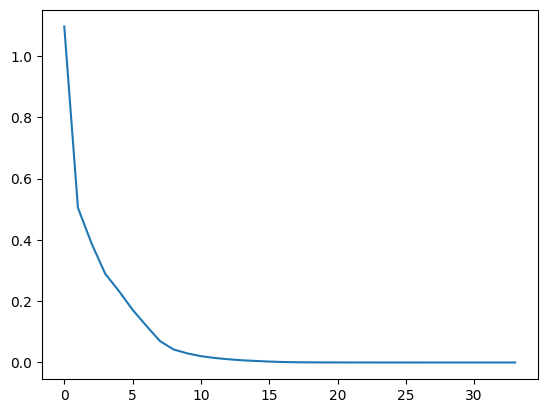

In [17]:
import matplotlib.pyplot as plt
obj_hist = fittedLR.summary.objectiveHistory
plt.plot(obj_hist)
plt.show()

#### Pipelines and hyperparameter tuning

In [18]:
print(str_id.explainParams())

handleInvalid: how to handle invalid data (unseen or NULL values) in features and label column of string type. Options are 'skip' (filter out rows with invalid data), error (throw an error), or 'keep' (put invalid data in a special additional bucket, at index numLabels). (default: error)
inputCol: input column name. (current: species)
inputCols: input column names. (undefined)
outputCol: output column name. (default: StringIndexer_fbb5d44ec4ab__output, current: label)
outputCols: output column names. (undefined)
stringOrderType: How to order labels of string column. The first label after ordering is assigned an index of 0. Supported options: frequencyDesc, frequencyAsc, alphabetDesc, alphabetAsc. Default is frequencyDesc. In case of equal frequency when under frequencyDesc/Asc, the strings are further sorted alphabetically (default: frequencyDesc)


In [19]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [20]:
lr.setRegParam(0.1)
fittedLR = lr.fit(train)
print(evaluator.evaluate(fittedLR.transform(train)))
print(evaluator.evaluate(fittedLR.transform(test)))

0.9238095238095239
0.7777777777777777


In [ ]:
from pyspark.ml.feature import RFormula

rf = RFormula(formula="species ~ . + sepal_length:sepal_width + petal_length:petal_width")

preparedDF = rf.fit(iris).transform(iris)

train, test = preparedDF.randomSplit([0.7, 0.3])

lr = LogisticRegression()
fittedLR = lr.fit(train)

print("Train accuracy:", evaluator.evaluate(fittedLR.transform(train)))
print("Test accuracy:", evaluator.evaluate(fittedLR.transform(test)))

Train accuracy: 1.0
Test accuracy: 0.9424413424413425


In [22]:
from pyspark.ml.pipeline import Pipeline
pipeline = Pipeline(stages = [rf, lr])
train, test = iris.randomSplit([.7, .3])
model = pipeline.fit(train)
print(evaluator.evaluate(model.transform(train)))
print(evaluator.evaluate(model.transform(test)))

0.9797979797979797
0.9803408721814794


In [23]:
iris.columns

['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

In [24]:
from pyspark.ml.tuning import ParamGridBuilder
rf0 = "species ~ ."
rf1 = "species ~ . ^ 2"
rf2 = "species ~ . + sepal_length:sepal_width + petal_length:petal_width"
params = ParamGridBuilder().addGrid(rf.formula, [rf0, rf1, rf2]).addGrid(lr.regParam, [0, 0.1, 0.2]).build()

In [26]:
from pyspark.ml.tuning import CrossValidator
cv = CrossValidator().setNumFolds(4).setEstimatorParamMaps(params).setEstimator(pipeline).setEvaluator(evaluator)
model = cv.fit(train) # Fit 9 models and pick the best one
evaluator.evaluate(model.transform(test))

1.0

In [27]:
print(evaluator.explainParams())

beta: The beta value used in weightedFMeasure|fMeasureByLabel. Must be > 0. The default value is 1. (default: 1.0)
eps: log-loss is undefined for p=0 or p=1, so probabilities are clipped to max(eps, min(1 - eps, p)). Must be in range (0, 0.5). The default value is 1e-15. (default: 1e-15)
labelCol: label column name. (default: label, current: label)
metricLabel: The class whose metric will be computed in truePositiveRateByLabel|falsePositiveRateByLabel|precisionByLabel|recallByLabel|fMeasureByLabel. Must be >= 0. The default value is 0. (default: 0.0)
metricName: metric name in evaluation (f1|accuracy|weightedPrecision|weightedRecall|weightedTruePositiveRate| weightedFalsePositiveRate|weightedFMeasure|truePositiveRateByLabel| falsePositiveRateByLabel|precisionByLabel|recallByLabel|fMeasureByLabel| logLoss|hammingLoss) (default: f1)
predictionCol: prediction column name. (default: prediction, current: prediction)
probabilityCol: Column name for predicted class conditional probabilities. 

In [30]:
print(model.bestModel.stages[1].explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must beequal wi

In [32]:
from pyspark.ml.tuning import TrainValidationSplit
tvs = TrainValidationSplit().setTrainRatio(0.7).setEstimatorParamMaps(params).setEstimator(pipeline).setEvaluator(evaluator)
model = tvs.fit(train)
evaluator.evaluate(model.transform(test))

0.9803408721814794

#### Artificial neural network

In [35]:
rf = RFormula(formula = "species ~ .")
from pyspark.ml.classification import MultilayerPerceptronClassifier
mlpc = MultilayerPerceptronClassifier(layers=[4,5,4,3])
pipeline = Pipeline(stages = [rf, mlpc])
train, test = iris.randomSplit([.7, .3])
model = pipeline.fit(train)
evaluator.evaluate(model.transform(iris))

0.9799819837854069